# Image Filtering and Hybrid Images


## Overview
The goal is to write an image filtering function and use it to create hybrid images using a simplified version of the SIGGRAPH 2006 [paper](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) by Oliva, Torralba, and Schyns. _Hybrid Images_ are static images that change in interpretation as a function of the viewing distance. The basic idea is that high frequency tends to dominate perception when it is available but, at a distance, only the low frequency (smooth) part of the signal can be seen. By blending the high frequency portion of one image with the low-frequency portion of another, we will get a hybrid image that leads to different interpretations at different distances.

There are 5 pairs of aligned images given which can be merged reasonably well into hybrid images. The alignment is super important because it affects the perceptual grouping (read the paper for details). 

## Import libraries

In [2]:
import os
import math

import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from typing import List

from utils import load_image, save_image, verify

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1D filtering

This part relies on the concept of filtering signals. A [low pass filter](https://en.wikipedia.org/wiki/Low-pass_filter) removes the high-frequency components of a signal. 

To demonstarte the concepts of filtering in 1-D, we will use simple sine waves. These waves have just one frequency component and hence it will be easy to understand the effects of filtering.

### 1.1 Sinusoids

In this part, we will dive into the concept behind low pass filtering and implement a Gaussian-kernel based low-pass filter.

Let us start with [sinusoids](https://en.wikipedia.org/wiki/Sine_wave) in 1D: sinusoids are a family of sine functions with varying frequency, amplitude, and phase.

$$f(x) = A \text{sin} \left(2 \pi \omega x + \phi \right)$$

where $A$ is the amplitude, $\omega$ is the frequency, and $\phi$ is the phase.

Let us now go through a utility function which will generate sinusoids for us for $x \in [0, 5]$ given the parameters:

In [3]:
fs = 40 # sampling frequency
x = torch.linspace(0, 5, int(5*fs))

In [4]:
def generate_1d_sinusoid(amplitude: float, frequency: float, phase: float) -> torch.Tensor:
    # Generates sinusoids with given parameters on input x.
    
    return amplitude * torch.sin(2 * math.pi * frequency * x + phase)

In [5]:
def plot_1d_signals(x: torch.Tensor, y_list: List[torch.Tensor], y_labels: List[str]):
    # Plots the 1d signals
    plt.figure()
    
    for (y, label) in zip(y_list, y_labels):
        plt.plot(x, y, label=label)
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
    plt.show()

Now generate two sinusoids: one low frequency and one high frequency

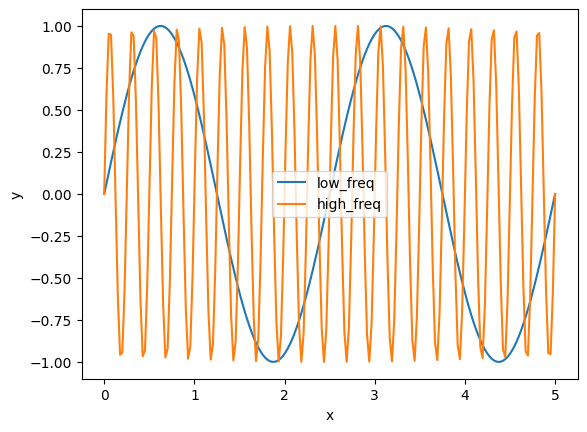

In [6]:
low_freq_sinusoid = generate_1d_sinusoid(1, 0.4, 0)
high_freq_sinusoid = generate_1d_sinusoid(1, 4, 0)
plot_1d_signals(x, [low_freq_sinusoid, high_freq_sinusoid], ['low_freq', 'high_freq'])

We will now linearly combine both the sinusoids to create a new **combined signal**. This signal will serve as an example for low-pass filters where will try to recover the low-frequency sinusoid back.

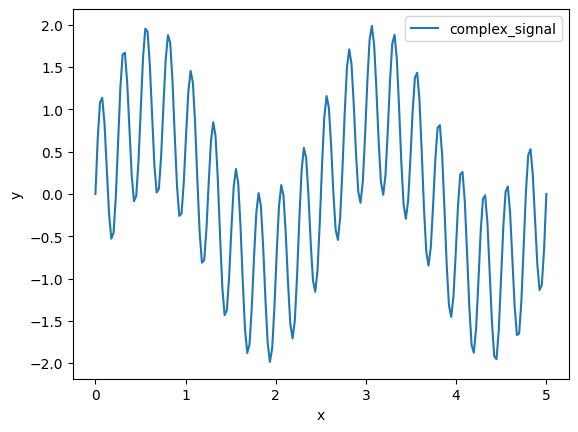

In [7]:
# linear addition of low_freq and high_freq sinusoid
combined_signal = low_freq_sinusoid + high_freq_sinusoid
plot_1d_signals(x, [combined_signal], ['complex_signal'])

We have created a signal with two frequency components. This can be useful to demonstrate low-pass filtering. Recall that low-pass filtering attenuates high-frequency components heavily, whereas the low-frequency components are left unchanged.

We will now design a low pass filter which recovers the low-frequency component from the combined signal.

Averaging operation is a good example of a low-pass filter. In this project, we will use averaging with Gaussian weights as a low-pass filter.

### 1D Gaussian as Low-Pass filters

A 1D Gaussian filter is of size $k$ is defined as: $$p(x; \mu, \sigma) = \frac{1}{Z} \exp \left( -\frac{\left( x - \mu \right)^2}{2 \sigma^2} \right)$$
where $Z$ is the normalizing coefficient such that the kernel sums to 1 over the range of the input $x \in [0, k)$, $x$ being integers.

The parameters $\mu$ and $\sigma$ are related to $k$ as:
* kernel size $k = 4*\sigma + 1$
* mean $\mu = \lfloor\frac{k}{2}\rfloor$

If we want to use this Gaussian kernel as a low-pass filter with cutoff frequency $\omega_c$ (i.e. allow components with frequency $\omega < \omega_c$ pass through and attenuate components with higher frequency), we need to define the kernel parameters as follows:
* standard deviation $\sigma = \frac{f_s}{2 \pi \omega_c}$.

We can hence use $\sigma$ as the paramterization of the kernel in this project. We can derive $k$ and $\mu$ using $\sigma$.

In [50]:
from filters import create_1d_gaussian_kernel

In [51]:
# helper function to visualize kernel
def plot_kernel(kernel: torch.Tensor):
    #Plots the kernel
    
    plt.figure()
    
    plt.plot(kernel)
    plt.xlabel('idx')
    plt.ylabel('p')
    
    plt.show()

We have two components at frequency 0.4 and 4. Hence we use 1.5 as the cutoff frequency:

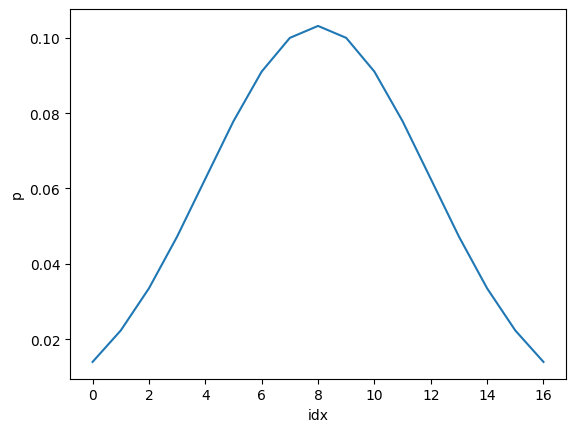

In [52]:
cutoff_frequency = 1.5
standard_deviation = fs/(2*math.pi*cutoff_frequency)

lowpass_1dfilter = create_1d_gaussian_kernel(standard_deviation)

plot_kernel(lowpass_1dfilter)

## Applying low-pass filter on combined signal (combination of sinusoids with two different frequencies)

We want to use the Gaussian kernel we created to filter out the high frequency sinusoid. For this, we need to implement the function to perform 1D filtering. Let's check that our low-pass filter using Gaussian kernel is working as expected by filtering the low pass and high pass signal separately.

In [53]:
from filters import my_1d_filter

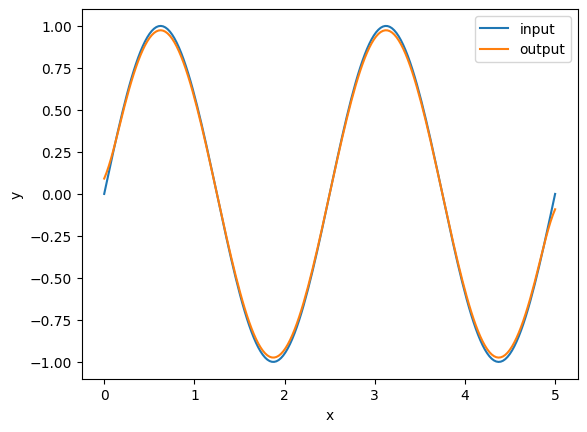

In [54]:
# applying on low frequency signal
filtered_low_freq_sinusoid = my_1d_filter(low_freq_sinusoid, lowpass_1dfilter)
plot_1d_signals(x, [low_freq_sinusoid, filtered_low_freq_sinusoid], ['input', 'output'])

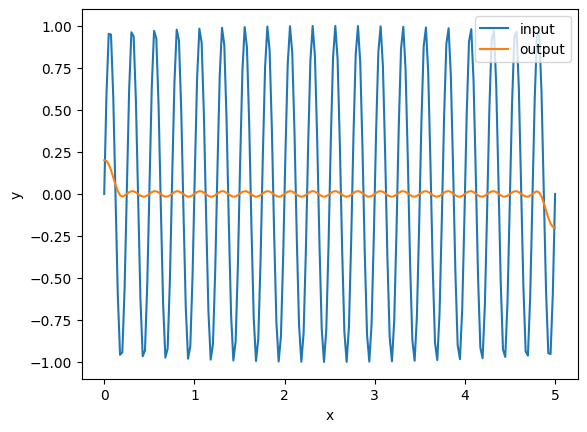

In [55]:
# applying on low frequency signal and plot the input
filtered_high_freq_sinusoid = my_1d_filter(high_freq_sinusoid, lowpass_1dfilter)
plot_1d_signals(x, [high_freq_sinusoid, filtered_high_freq_sinusoid], ['input', 'output'])

Now, lets observe what happens when we apply this filter to the combined signal:

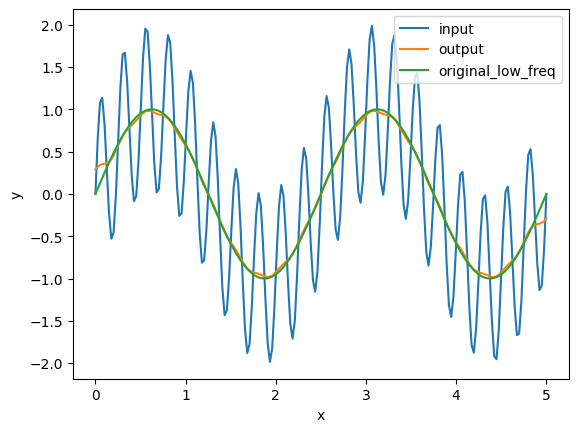

In [56]:
filtered_combined_signal = my_1d_filter(combined_signal, lowpass_1dfilter)
plot_1d_signals(x, [combined_signal, filtered_combined_signal, low_freq_sinusoid], ['input', 'output', 'original_low_freq'])

## Implementing hybrid images in Pytorch manually

**Gaussian Kernels.** Gaussian filters are used for blurring images.

The multivariate Gaussian function is defined as:

$$p(x;\mu, \Sigma) = \frac{1}{(2\pi)^{n/2}\det(\Sigma)^{1/2}}\exp\bigg(-\frac{1}{2}(x-\mu)^\top\Sigma^{-1}(x-\mu)\bigg)$$

where $n$ is equal to the dimension of $x$, $\mu$ is the mean, and $\Sigma$ is the covariance matrix. Similar to 1.2, we will use $\sigma$ as the hyperparameter of the 2D kernel. The kernel shape is $(k,k)$ and the mean is $\mu$ in each dimension. They are related to $\sigma$ as:
- $k = 4*\sigma + 1$
- $\mu= \begin{bmatrix} \lfloor\frac{k}{2}\rfloor \\ \lfloor\frac{k}{2}\rfloor \end{bmatrix}$
- $\Sigma = \begin{bmatrix} \sigma^2 & 0 \\ 0 & \sigma^2 \end{bmatrix}$

Alternatively, we can create a 2D Gaussian by taking the outer product of two vectors. Each such vector should have values populated from evaluating the 1D Gaussian PDF at each coordinate. The 1D Gaussian, as we saw in part 1.2, is defined as:
$$p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma} \mbox{exp} \Bigg(-\frac{1}{2\sigma^2}(x-\mu)^2 \Bigg)$$



Note that the sum of values in the 2D kernel should sum to 1.

We will be implementing `create_2D_Gaussian_kernel()` that creates a 2D Gaussian kernel according to a free parameter, _standard deviation_, which controls how much low frequency to leave in the image. This is an important step for later in the project when creating hybrid images.

**Image Filtering.** Image filtering (or convolution) is a fundamental image processing tool. Here we will write a function to implement image filtering from scratch. More specifically, we will implement `my_imfilter()` which imitates the `filter2D()` function in the OpenCV library. As specified, the filtering algorithm must: (1) support grayscale and color images, (2) support arbitrarily-shaped filters, as long as both dimensions are odd (e.g. 7x9 filters, but not 4x5 filters), (3) pad the input image with zeros or reflected image content, and (4) return a filtered image which is the same resolution as the input image.

**Hybrid Images.** A hybrid image is the sum of a low-pass filtered version of one image and a high-pass filtered version of another image. As mentioned in above, _cutoff standarddeviation_ controls how much high frequency to leave in one image and how much low frequency to leave in the other image. In `cutoff_standarddeviation.txt`, here is a default value of 7 for each pair of images (the value on line _i_ corresponds to the cutoff value for the _i_-th image pair). We will replace these values with the ones we find work best for each image pair.

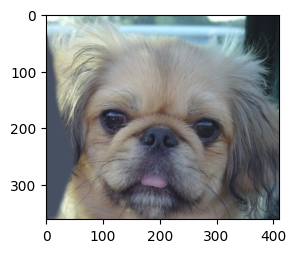

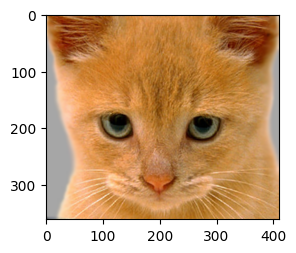

In [57]:
from utils import load_image, save_image

image1 = load_image('data/1a_dog.bmp')
image2 = load_image('data/1b_cat.bmp')

# display the dog and cat images
plt.figure(figsize=(3,3)); plt.imshow((image1*255).byte())
plt.figure(figsize=(3,3)); plt.imshow((image2*255).byte());

### Create filter

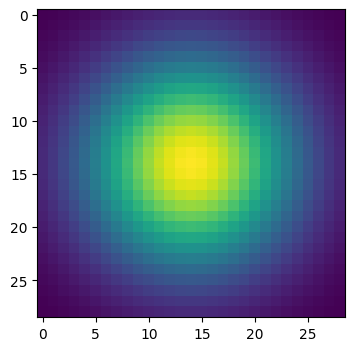

In [58]:
from filters import create_2d_gaussian_kernel

cutoff_standard_deviation = 7
kernel = create_2d_gaussian_kernel(cutoff_standard_deviation)

# let's take a look at the filter!
plt.figure(figsize=(4,4)); plt.imshow(kernel);

### Apply filter to image
Start by implementing `my_imfilter`, which takes both a filter and an image, and returns the filtered image. This code block will use our `my_imfilter` function to create and display a blurry version of our image.

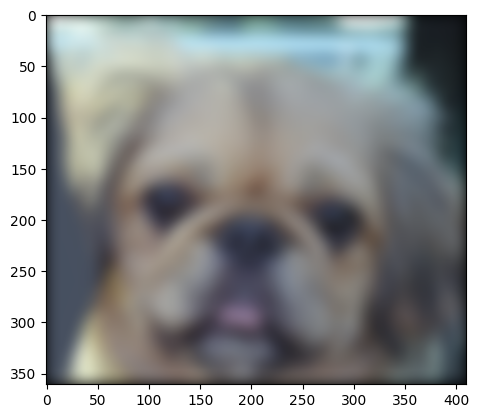

In [59]:
from filters import my_imfilter

blurry_image = my_imfilter(image1, kernel)

plt.figure(); plt.imshow((blurry_image*255).byte());

### Create hybrid image

Next, takes two images and makes a hybrid image using the low frequency content from one image and the high frequency content from another by applying the Gaussian kernel we have defined.

In [60]:
from filters import create_hybrid_image
from utils import vis_image_scales_numpy

low_freq_image, high_freq_image, hybrid_image = create_hybrid_image(image1, image2, kernel)

vis = vis_image_scales_numpy(hybrid_image)

### Show results

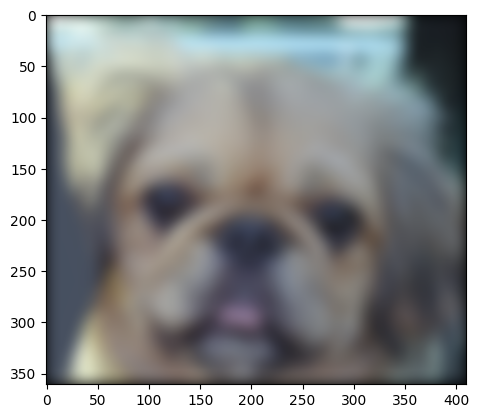

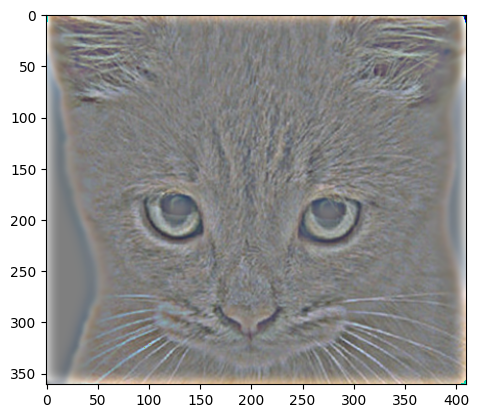

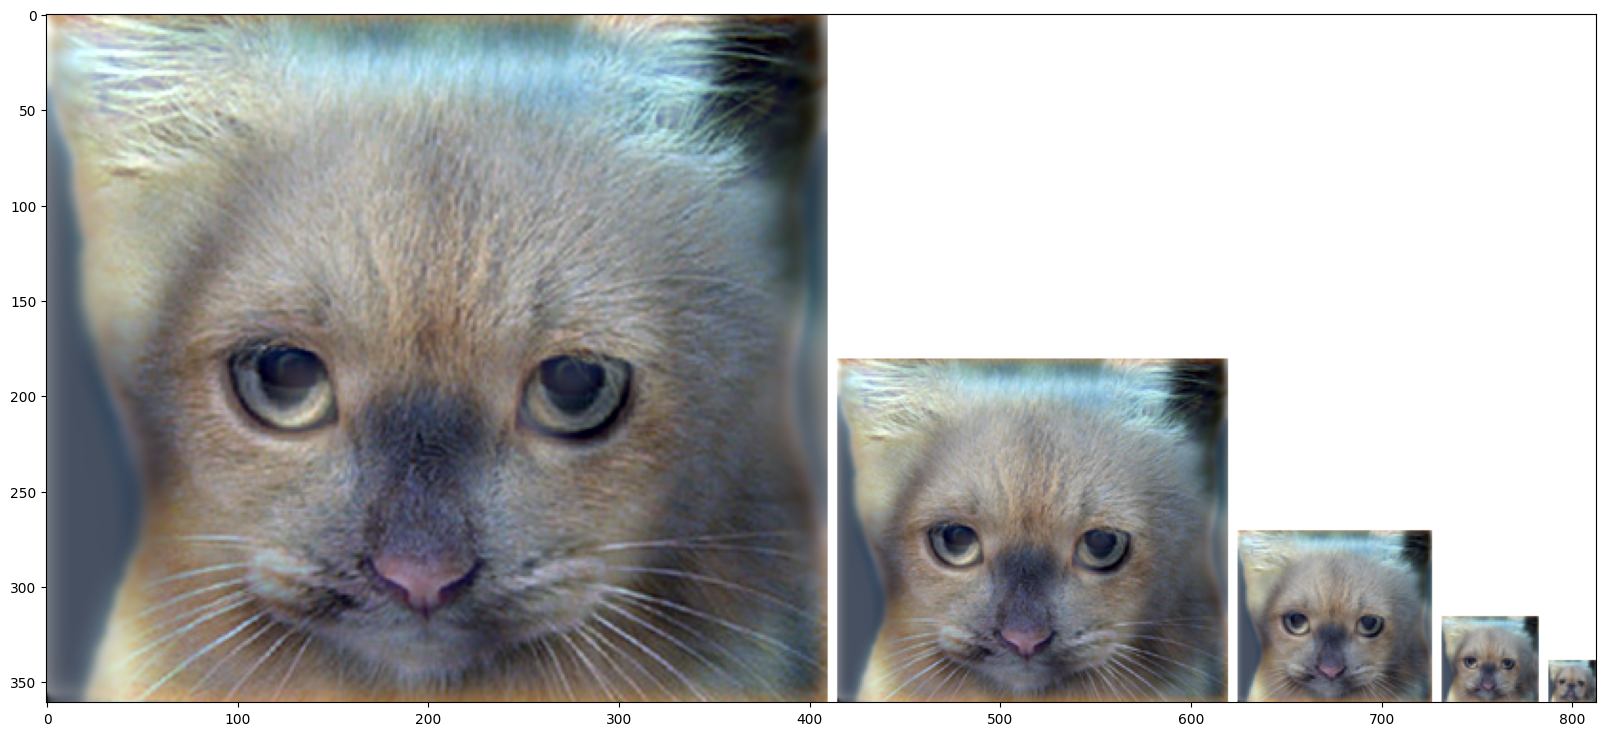

In [61]:
plt.figure(); plt.imshow((low_freq_image * 255).byte());
plt.figure(); plt.imshow(((high_freq_image + 0.5) * 255).byte());
plt.figure(figsize=(20, 20)); plt.imshow(vis);

### Save results

In [62]:
os.makedirs("../results/part2", exist_ok=True)
save_image('../results/part2/low_freq_image.jpg', low_freq_image)
save_image('../results/part2/high_freq_image.jpg', high_freq_image + 0.5)
save_image('../results/part2/hybrid_image.jpg', hybrid_image)
save_image('../results/part2/hybrid_image_scales.jpg', vis)

## Using PyTorch's inbuilt operators

**Dataloader:** Now implement creating hybrid images again but using PyTorch. The `HybridImageDataset` class in `student_code.py` will create tuples using pairs of images with a corresponding cutoff standard deviation (which we should have found from experimenting in Part 2). The images will be loaded from `data/` and the cutoff standard deviation from `cutoff_standarddeviations.txt`. Refer to [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for additional information on data loading & processing.

**Model:** Next, we will implement the `HybridImageModel` class in the `filters.py`. Instead of using implementation of `my_imfilter()` to get the low and high frequencies from a pair of images, `low_pass()` should use the 2d convolution operator from `torch.nn.functional` to apply a low pass filter to a given image. We will have to implement `get_kernel()` which calls the `create_2d_gaussian_kernel()` function for each pair of images using the cutoffs as specified in `cutoff_standarddeviations.txt` and reshapes it to the appropriate dimensions for PyTorch. Then, similar to `create_hybrid_image()`, `forward()` will call `get_kernel()` and `low_pass()` to create the low and high frequency images and combine them into a hybrid image. Refer to [this tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) for additional information on defining neural networks using PyTorch.

In [63]:
import torch
import torchvision

from student_code import HybridImageDataset
from student_code import HybridImageModel


data_root = 'data/'
cf_file = 'cutoff_standarddeviations.txt'

### Instantiate model & dataset
Implement `HybridImageModel` and `HybridImageDataset` in `student_code.py`.

In the code documentation, we will see a term called "batch size", which we will discuss in later projects and lectures. For now, we are using the default value of 1. 

In [64]:
model = HybridImageModel()
dataset = HybridImageDataset(data_root, cf_file)
dataloader = torch.utils.data.DataLoader(dataset)

### Create hybrid images
This code block will iterate through pairs of images from dataset and create a hybrid image using the low frequency content from one image and the high frequency content from another.

In [65]:
for i, sample in enumerate(dataloader):
    image_a, image_b, cutoff_standarddeviation = sample
    low_frequencies, high_frequencies, hybrid_image = model(image_a, image_b, cutoff_standarddeviation)
    
    os.makedirs("../results/part3", exist_ok=True)
    # saves low frequencies, high frequencies, and hybrid image of each pair of images
    torchvision.utils.save_image(low_frequencies, '../results/part3/%d_low_frequencies.jpg' % i)
    torchvision.utils.save_image(high_frequencies+0.5, '../results/part3/%d_high_frequencies.jpg' % i)
    torchvision.utils.save_image(hybrid_image, '../results/part3/%d_hybrid_image.jpg' % i)

In [66]:
## Verify that the results are correct, with cutoff_frequency of 7
from proj1_unit_tests.test_2d import (
    verify_low_freq_sq_kernel_pytorch, 
    verify_high_freq_sq_kernel_pytorch,
    verify_hybrid_image_pytorch
)

dataset = HybridImageDataset(data_root, cf_file)
dataloader = torch.utils.data.DataLoader(dataset)
image_a, image_b, cutoff = next(iter(dataloader))
low_frequencies, high_frequencies, hybrid_image = model(image_a, image_b, cutoff)

cutoff_sd = torch.Tensor([7])

### Hybrid image timing comparison
Here, we will compare the runtime of creating hybrid images using manual Torch implementation to the PyTorch implementation.

In [67]:
import time

image1 = load_image('data/1a_dog.bmp')
image2 = load_image('data/1b_cat.bmp')

In [68]:
start = time.time()
cutoff_standarddeviation = 7
kernel = create_2d_gaussian_kernel(cutoff_standarddeviation)
low_frequencies, high_frequencies, hybrid_image = create_hybrid_image(image1, image2, kernel)
end = time.time() - start
print('Gaussian Kernel : {:.3f} seconds'.format(end))

Gaussian Kernel : 22.691 seconds


Timing Hybrid Model:

In [69]:
model = HybridImageModel()

start = time.time()
low_frequencies, high_frequencies, hybrid_image = model(image_a, image_b, torch.Tensor([cutoff_standarddeviation]))
end = time.time() - start
print('Hybrid Model: {:.3f} seconds'.format(end))

Hybrid Model: 0.140 seconds


### Median Filtering

In this section, we will implement a median filter and apply it on an image (grayscale only). A median filter is a non-linear filter that is used for noise reduction in images / other signals. For a window of size $(N, N)$, a median filter replaces the center pixel of the neighborhood with the median value of all the pixels in the window. An example of a 2D median filter is given below:

![median_filter](./data/median_filter.jpeg "Median Filter")

In the above example, a kernel of size $3 \times 3$ is applied over a region of the image and the center pixel is being replaced by the value $9$, which is the median of all the pixel values in this region. 

### Median Filter

Implement the `my_median_filter` function based on the given below information:
- The input image will always be a grayscale image of dimensions $(m, n, 1)$ or $(m, n)$.
- The filter size will always be odd and it can either be a scalar value or a tuple of integers
- The output must be a tensor of dimensions $(m, n, 1)$. To ensure that the spatial resolution remains the same, zero-padding should be used here.

Let us load the image 

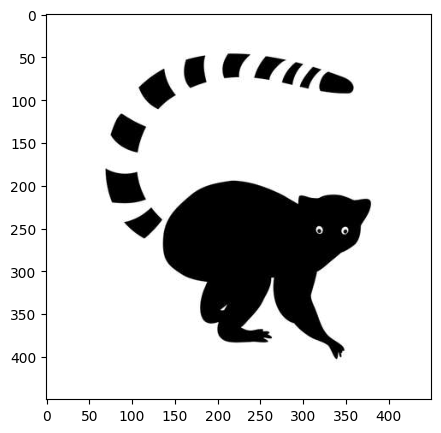

In [70]:
median_img = Image.open('data/median_filter_test.jpeg').convert('L')
plt.figure(figsize=(5,5)); plt.imshow((np.array(median_img)), cmap='gray')

#### Applying median filter 
Here, we will apply the median filter on the above given image. Test several different values for filter size and observe the differences in the output. 
1. What happens to the corners of the images when the filter size is very large? Is there a simple explanation for the same?
2. Think of a few methods to avoid the above issue (if any). Are there an disadvantages of using these methods over simple zero padding of the input image?
3. Apply the median filter on the coin.png image given in the data folder. Is the median filter able to remove the noise to a certain extent? Can we use a Gaussian filter instead of the median filter for the same purpose?

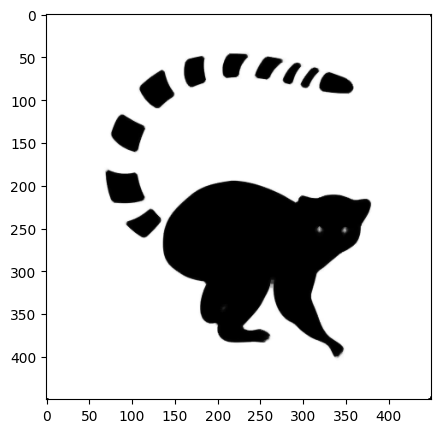

In [73]:
from filters import my_median_filter
median_img_torch = torch.tensor(np.array(median_img), dtype=torch.float)

# Code output
my_output = my_median_filter(median_img_torch, (7, 7))
my_output = my_output.squeeze(2).numpy()

plt.figure(figsize=(5,5)); plt.imshow((np.array(my_output)), cmap='gray')

#  DFT

Now we will implement the Discrete Fourier Transform matrix, and use it to run DFT for 2D images, and implement a low-pass filter based on DFT analysis results. 

### DFT for 2D signal

An N-point DFT is expressed as the multiplication $X=Wx$, where $x$ is the original input signal, $W$ is the N-by-N square DFT matrix, and $X$ is the DFT of the signal. The [wiki](https://en.wikipedia.org/wiki/DFT_matrix) provides a good introduction on DFT matrix for a 1D signal. The DFT equation for a 2D square matrix is:
$$U_{mn}=\frac{1}{M}e^{-j\frac{2\pi mn}{M}}$$
where $M=N$. 

Next we begin with a simple situation where we assume all the 2D image matrices are square, grayscale matrices, which would make our life easier.

In [74]:
def dft_matrix(N):
    U = torch.Tensor()

    torch.pi = torch.acos(torch.zeros(1)).item() * \
        2  # which is 3.1415927410125732

    U = torch.zeros(N, N, 2)
    for i in range(N):
        for j in range(N):
            U[i, j, 0] = (1/N) * torch.cos(torch.tensor(2 * torch.pi * i * j) / N)
            U[i, j, 1] = (-1/N) * torch.sin(torch.tensor(2 * torch.pi * i * j) / N)
    return U

### Image filtering based on Discrete Fourier Transform (DFT)

A brief review on the DFT for 2D images:
$$F[k,l]=\sum_{m=0}^{M-1}\sum_{n=0}^{N-1}f[m,n]exp(-j\frac{2\pi}{M}km-j\frac{2\pi}{N}ln)$$
where $$0\leq k \leq M-1$$ $$0\leq l \leq N-1$$

We observe that the DFT transform of each row is independent from that of the column. This means in order to obtain the 2D DFT transform, we can run a 1D DFT of then columns, then a 1D DFT of rows consecutively (or rows first, then columns). That would save us a lot of computation.

In [75]:
def my_dft(img):

    dft = torch.Tensor()

    assert img.shape[0] == img.shape[1], "Input image should be a square matrix"

    N = img.size()[0]
    U = dft_matrix(N)

    real = complex_multiply_real(U, img)
    dft = complex_multiply_complex(real, U)

    return dft

### Generate low-pass filter

Finally, we implement a low-pass filter based on DFT, the resolution is 512x512.

In [ ]:
from PIL import Image, ImageOps
from filters import dft_filter
import torchvision.transforms as transforms

image6 = Image.open('data_part4/6a_dog.bmp')
image_gray = transforms.ToTensor()(image6)[0,:,:]
img_dft_filter = dft_filter(image_gray)

plt.subplot(121), plt.imshow(image_gray, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_dft_filter, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()